In [323]:
# Kunskapskontroll DS24
## Databasanalys med AdventureWorks2022
##I denna Notebook analyserar vi data från AdventureWorks2022 med hjälp av SQL och Python.
import pandas as pd  # Importerar Pandas för att hantera och analysera data i tabellform (DataFrames).
import numpy as np  # Importerar NumPy för numeriska beräkningar.
from sqlalchemy import create_engine  # Från SQLAlchemy, skapar en anslutning till databasen.
import matplotlib.pyplot as plt  # Importerar Matplotlib för att skapa grafer och visualisera data.
import seaborn as sns  # Importerar Seaborn för förbättrade visualiseringar.
from scipy.stats import norm  # Importerar normalfördelningen från SciPy för statistiska analyser.
from scipy import stats  # Importerar ytterligare statistiska verktyg från SciPy.

In [315]:

# Ange anslutningssträngen
connection_string = "mssql+pyodbc://@localhost/AdventureWorks2022?driver=ODBC+Driver+17+for+SQL+Server"  
# connection_string: Specificerar hur vi ansluter till databasen. 
# 'mssql+pyodbc': Anger att vi använder Microsoft SQL Server via ODBC.
# 'localhost': Databasen finns lokalt.
# 'AdventureWorks2022': Namnet på databasen.
# 'driver=ODBC+Driver+17+for+SQL+Server': Anger vilken drivrutin som används.

# Skapa en engine för att ansluta till databasen
engine = create_engine(connection_string)  
# engine: Hanterar kommunikationen mellan Python och databasen.

# Testa anslutningen
try:
    with engine.connect() as connection:  # Försöker ansluta till databasen.
        print("Anslutning till databasen lyckades!")  # Skriver ut om anslutningen är framgångsrik.
except Exception as e:  # Fångar eventuella fel som uppstår vid anslutning.
    print(f"Fel vid anslutning: {e}")  # Skriver ut felmeddelandet om anslutningen misslyckas.



Anslutning till databasen lyckades!



1. Försäljningsanalys

Månadsvis försäljningsdata:
 Month   TotalSales  CustomerCount  AvgOrderValue  GrowthRate
     1 1.159643e+07           2620      4030.7357         NaN
     2 5.727484e+06           2156      2490.2104  -50.609924
     3 1.526499e+07           2856      4855.2766  166.521732
     4 6.698521e+06           2654      2382.1197  -56.118406
     5 1.368421e+07           2957      4309.9885  104.287094
     6 1.089816e+07           2012      4978.6022  -20.359615
     7 1.165426e+07           2192      4946.6278    6.937820
     8 8.977000e+06           2167      3862.7368  -22.972337
     9 9.520021e+06           2128      4139.1396    6.049023
    10 1.338871e+07           2391      5118.0067   40.637352
    11 6.607134e+06           2537      2432.6708  -50.651435
    12 9.199874e+06           2403      3463.8080   39.241522


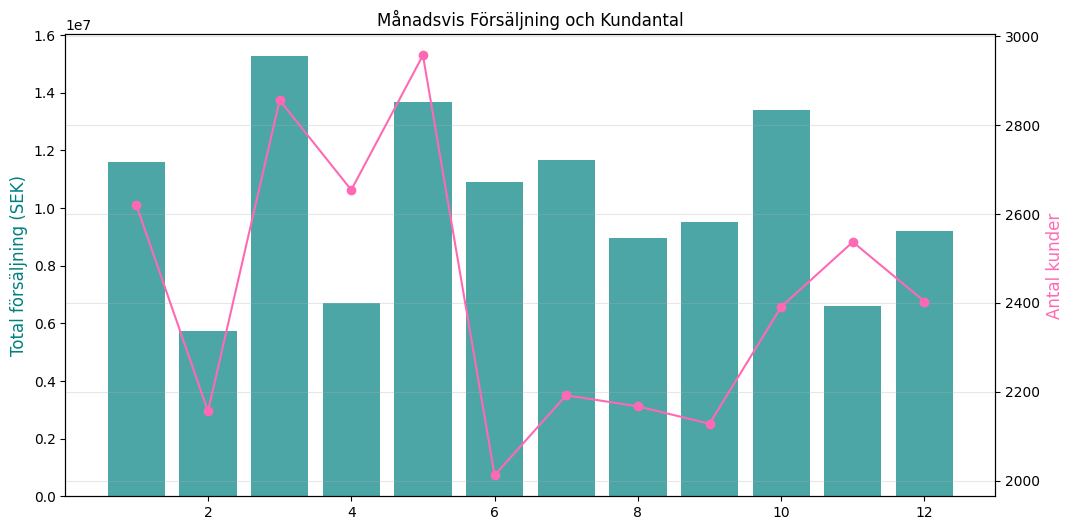

In [317]:
# 1. FÖRSÄLJNINGSANALYS
print("\n1. Försäljningsanalys\n")

monthly_sales_query = """
SELECT 
    MONTH(OrderDate) as Month,  -- Hämtar månad från OrderDate
    SUM(TotalDue) as TotalSales,  -- Summerar total försäljning per månad
    COUNT(DISTINCT CustomerID) as CustomerCount,  -- Räknar unika kunder
    AVG(TotalDue) as AvgOrderValue  -- Genomsnittligt ordervärde
FROM Sales.SalesOrderHeader
GROUP BY MONTH(OrderDate)
ORDER BY Month;
"""

monthly_sales = pd.read_sql(monthly_sales_query, engine)  # Läser in data från SQL-frågan
monthly_sales['GrowthRate'] = monthly_sales['TotalSales'].pct_change() * 100  # Beräknar tillväxt

print("Månadsvis försäljningsdata:")
print(monthly_sales.to_string(index=False))

# Visualisera månadsvis försäljning
fig, ax1 = plt.subplots(figsize=(12, 6))  # Skapar figur med två y-axlar
ax2 = ax1.twinx()  # Andra y-axeln

bar_plot = ax1.bar(monthly_sales['Month'], monthly_sales['TotalSales'], color='teal', alpha=0.7)  # Staplar
line_plot = ax2.plot(monthly_sales['Month'], monthly_sales['CustomerCount'], 
                     color='hotpink', marker='o')  # Linje

ax1.set_ylabel('Total försäljning (SEK)', color='teal', size=12)
ax2.set_ylabel('Antal kunder', color='hotpink', size=12)
plt.title('Månadsvis Försäljning och Kundantal')
plt.grid(True, alpha=0.3)
plt.show()



2. KUNDANALYS - Topp städer

Topp 5 städer:
   City   TotalSales  CustomerCount  AvgOrderValue
Toronto 5034269.5919             23     28603.8044
 London 3071176.6386            433      4062.4029
  Paris 2233808.1989            397      3884.8838
Seattle 1767263.4736             95     13287.6952
Burnaby 1503463.8536             32     15341.4678


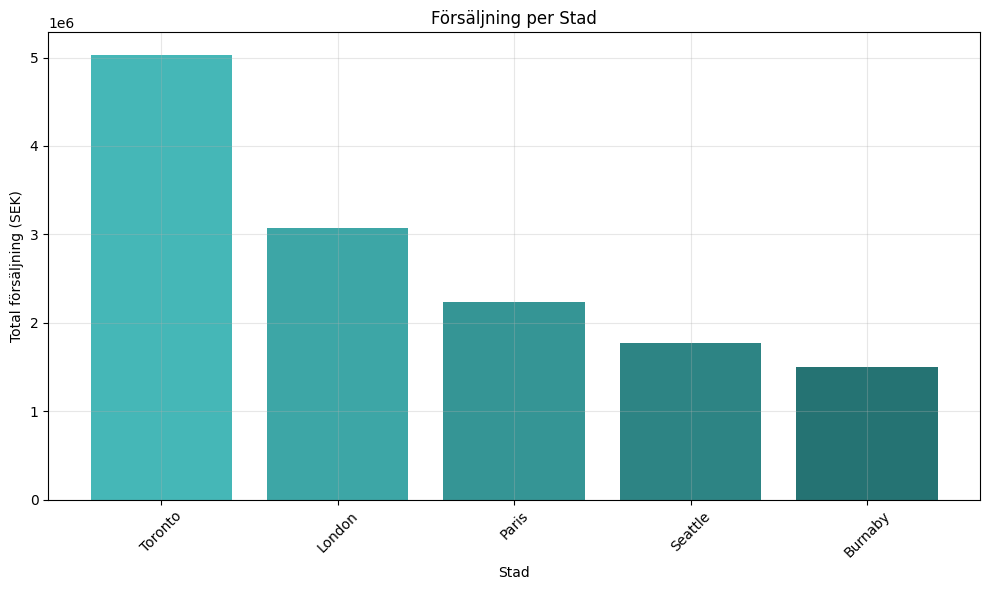

In [318]:
# 2. KUNDANALYS
print("\n2. KUNDANALYS - Topp städer\n")

city_query = """
SELECT TOP 5
    a.City,  -- Stadens namn
    SUM(soh.TotalDue) as TotalSales,  -- Total försäljning
    COUNT(DISTINCT soh.CustomerID) as CustomerCount,  -- Antal kunder
    AVG(soh.TotalDue) as AvgOrderValue  -- Snittorder
FROM Sales.SalesOrderHeader soh
JOIN Person.Address a ON soh.ShipToAddressID = a.AddressID
GROUP BY a.City
ORDER BY TotalSales DESC;
"""

city_data = pd.read_sql(city_query, engine)  # Hämtar stadsdata

print("Topp 5 städer:")
print(city_data.to_string(index=False))

plt.figure(figsize=(10, 6))
plt.bar(city_data['City'], city_data['TotalSales'], 
        color=['#45B7B7', '#3DA6A6', '#359595', '#2D8484', '#257373'])  # Stapeldiagram med teal-nyanser
plt.title('Försäljning per Stad')
plt.xlabel('Stad')
plt.ylabel('Total försäljning (SEK)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


3. PRODUKTANALYS

Produktkategorier:
   Category   TotalSales  OrderCount  AvgPrice  SalesShare
      Bikes 9.465117e+07       18368 1254.6615   86.166855
 Components 1.180259e+07        2650  251.3764   10.744635
   Clothing 2.120543e+06        9877   32.1051    1.930462
Accessories 1.272073e+06       19524   19.6945    1.158047


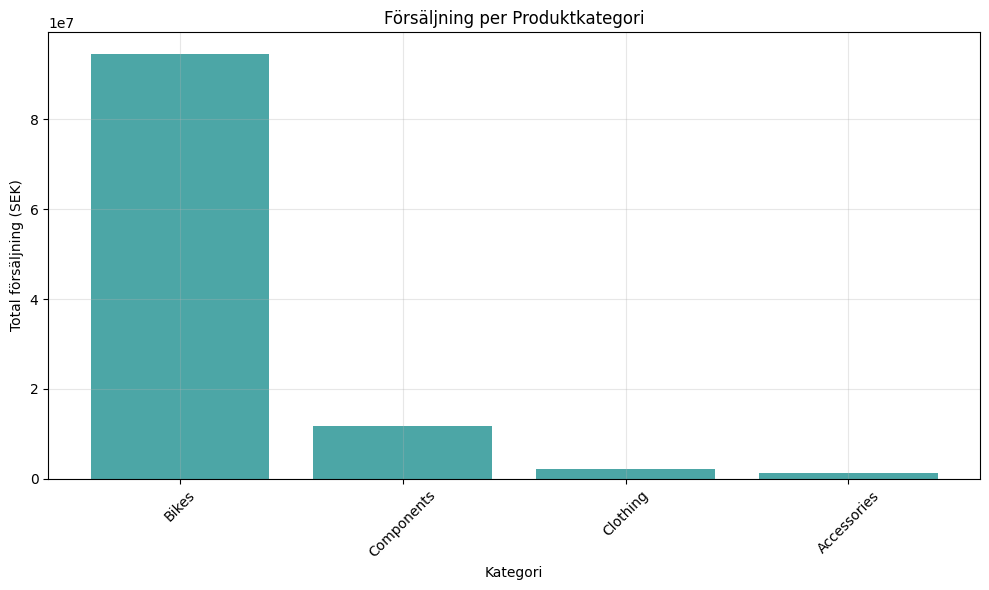

In [319]:
# 3. PRODUKTANALYS
print("\n3. PRODUKTANALYS\n")

product_query = """
SELECT 
    pc.Name as Category,  -- Kategorinamn
    SUM(sod.LineTotal) as TotalSales,  -- Total försäljning
    COUNT(DISTINCT sod.SalesOrderID) as OrderCount,  -- Antal ordrar
    AVG(sod.UnitPrice) as AvgPrice  -- Snittpris
FROM Production.ProductCategory pc
JOIN Production.ProductSubcategory psc ON pc.ProductCategoryID = psc.ProductCategoryID
JOIN Production.Product p ON psc.ProductSubcategoryID = p.ProductSubcategoryID
JOIN Sales.SalesOrderDetail sod ON p.ProductID = sod.ProductID
GROUP BY pc.Name
ORDER BY TotalSales DESC;
"""

product_data = pd.read_sql(product_query, engine)
product_data['SalesShare'] = (product_data['TotalSales'] / product_data['TotalSales'].sum()) * 100  # Marknadsandel

print("Produktkategorier:")
print(product_data.to_string(index=False))

plt.figure(figsize=(10, 6))
plt.bar(product_data['Category'], product_data['TotalSales'], color='teal', alpha=0.7)
plt.title('Försäljning per Produktkategori')
plt.xlabel('Kategori')
plt.ylabel('Total försäljning (SEK)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [320]:
# 4. KAMPANJANALYS
print("\n4. KAMPANJANALYS\n")

campaign_query = """
SELECT 
    p.Name as ProductName,  -- Hämtar produktnamnet
    COUNT(DISTINCT sod.SalesOrderID) as OrderCount,  -- Räknar unika ordrar
    SUM(sod.LineTotal) as TotalSales,  -- Summerar total försäljning
    AVG(sod.UnitPriceDiscount * 100) as AvgDiscountPercent  -- Beräknar genomsnittlig rabatt i procent
FROM Sales.SalesOrderDetail sod
JOIN Production.Product p ON sod.ProductID = p.ProductID
JOIN Production.ProductSubcategory ps ON p.ProductSubcategoryID = ps.ProductSubcategoryID
JOIN Production.ProductCategory pc ON ps.ProductCategoryID = pc.ProductCategoryID
WHERE sod.UnitPriceDiscount > 0 AND pc.Name = 'Bikes'
GROUP BY p.Name
ORDER BY TotalSales DESC;
"""

campaign_data = pd.read_sql(campaign_query, engine)

# Formatera och visa tabellen med rutnät och styling
print("\nKampanjresultat för premiumprodukter (Cyklar):")
styled_table = campaign_data.style\
    .set_properties(**{
        'border': '1px solid black',
        'padding': '8px',
        'text-align': 'center'
    })\
    .set_table_styles([
        {'selector': 'th',
         'props': [
             ('background-color', '#f2f2f2'),
             ('border', '1px solid black'),
             ('padding', '8px'),
             ('text-align', 'center')
         ]},
        {'selector': '',
         'props': [('border-collapse', 'collapse')]}
    ])
display(styled_table)


4. KAMPANJANALYS


Kampanjresultat för premiumprodukter (Cyklar):


,ProductName,OrderCount,TotalSales,AvgDiscountPercent
0,"Touring-1000 Yellow, 60",79,360428.709147,18.253100
1,"Road-350-W Yellow, 48",25,333124.433085,3.360000
2,"Touring-1000 Yellow, 46",73,246735.033324,19.369800
3,"Touring-1000 Blue, 60",13,235013.276355,2.923000
4,"Road-350-W Yellow, 40",14,187542.822549,3.071400
5,"Mountain-200 Black, 38",11,181483.220200,2.818100
6,"Road-650 Red, 44",80,163700.658888,23.500000
7,"Touring-1000 Blue, 46",9,162233.341023,3.000000
8,"Road-650 Red, 60",25,150112.572514,2.720000
9,"Road-650 Black, 52",25,148852.665230,2.960000


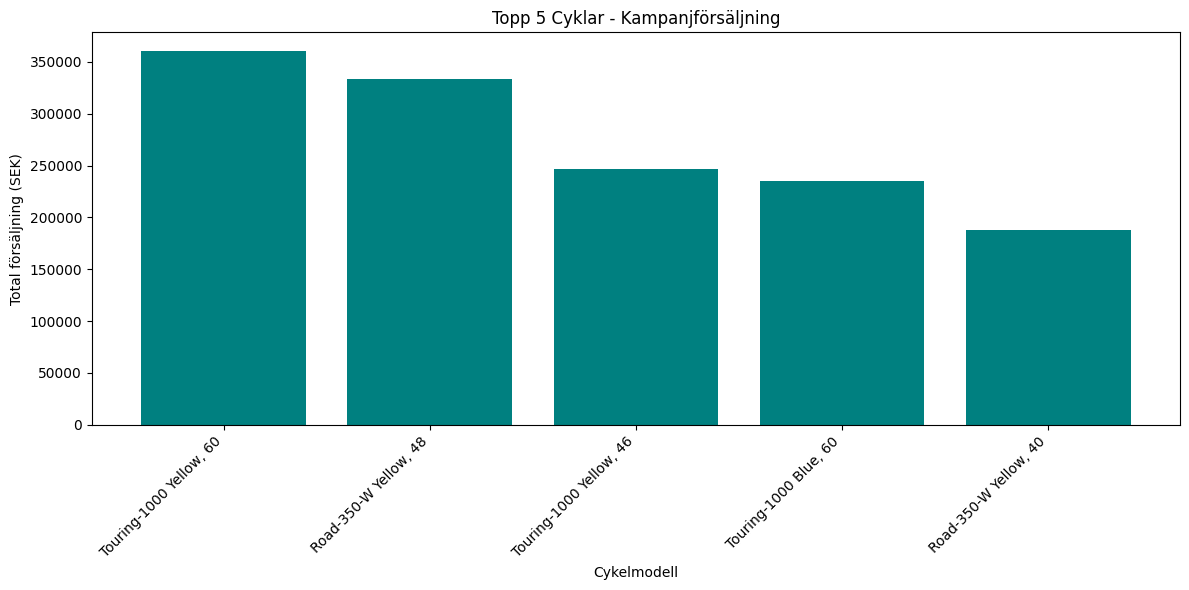

In [324]:
# Visualisera kampanjförsäljning för topp 5 cyklar
plt.figure(figsize=(12, 6))
top_5_bikes = campaign_data.head(5)
plt.bar(top_5_bikes['ProductName'], top_5_bikes['TotalSales'], color='teal')
plt.title('Topp 5 Cyklar - Kampanjförsäljning')
plt.xlabel('Cykelmodell')
plt.ylabel('Total försäljning (SEK)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


5. LEVERANTÖRSANALYS


Topp 5 leverantörer:


,Supplier,OrderCount,TotalValue
0,Chicago City Saddles,51,18191.700000
1,Superior Bicycles,50,10650.000000
2,First Rate Bicycles,51,6063.900000
3,Expert Bike Co,51,6063.900000
4,Professional Athletic Consultants,50,5403.500000


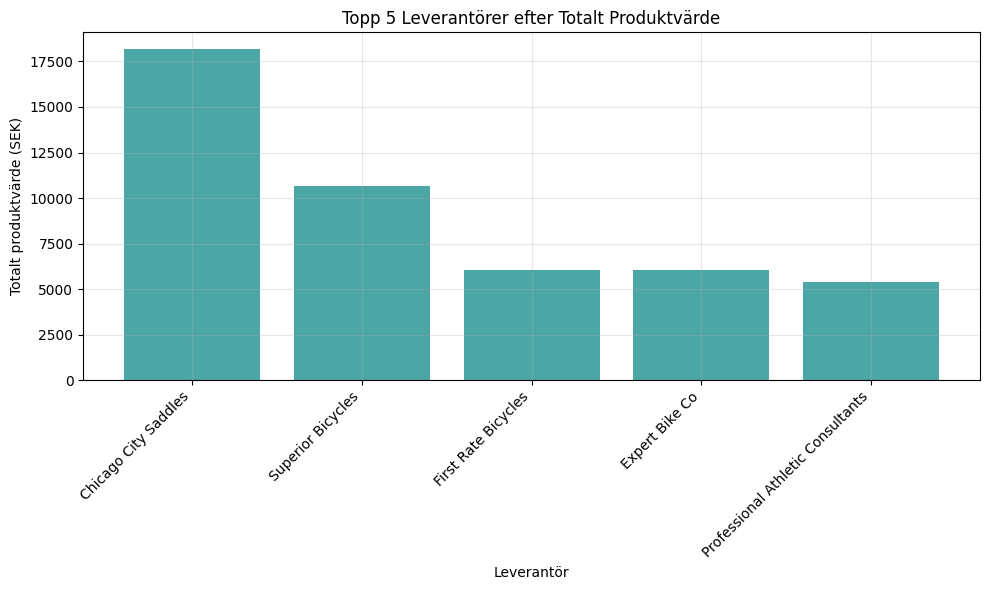

In [321]:
# 5. LEVERANTÖRSANALYS
print("\n5. LEVERANTÖRSANALYS\n")

supplier_query = """
SELECT TOP 5
   v.Name as Supplier,  -- Leverantörsnamn
   COUNT(DISTINCT poh.PurchaseOrderID) as OrderCount,  -- Antal ordrar
   SUM(p.ListPrice) as TotalValue  -- Totalt värde
FROM Purchasing.Vendor v
JOIN Purchasing.ProductVendor pv ON v.BusinessEntityID = pv.BusinessEntityID
JOIN Production.Product p ON pv.ProductID = p.ProductID
LEFT JOIN Purchasing.PurchaseOrderHeader poh ON v.BusinessEntityID = poh.VendorID
GROUP BY v.Name
ORDER BY TotalValue DESC;
"""

supplier_data = pd.read_sql(supplier_query, engine)

# Formatera och visa tabellen med rutnät och styling
print("\nTopp 5 leverantörer:")
styled_table = supplier_data.style\
   .set_properties(**{
       'border': '1px solid black',
       'padding': '8px',
       'text-align': 'center'
   })\
   .set_table_styles([
       {'selector': 'th',
        'props': [
            ('background-color', '#f2f2f2'),
            ('border', '1px solid black'),
            ('padding', '8px'),
            ('text-align', 'center')
        ]},
       {'selector': '',
        'props': [('border-collapse', 'collapse')]}
   ])
display(styled_table)



plt.figure(figsize=(10, 6))
plt.bar(supplier_data['Supplier'], supplier_data['TotalValue'], color='teal', alpha=0.7)
plt.title('Topp 5 Leverantörer efter Totalt Produktvärde')
plt.xlabel('Leverantör')
plt.ylabel('Totalt produktvärde (SEK)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


6. STATISTISK ANALYS

Genomsnittligt försäljningsbelopp: 3452.68 SEK
Standardavvikelse: 12145.83 SEK
Antal ordrar: 14182
95% konfidensintervall: (3252.76, 3652.59) SEK


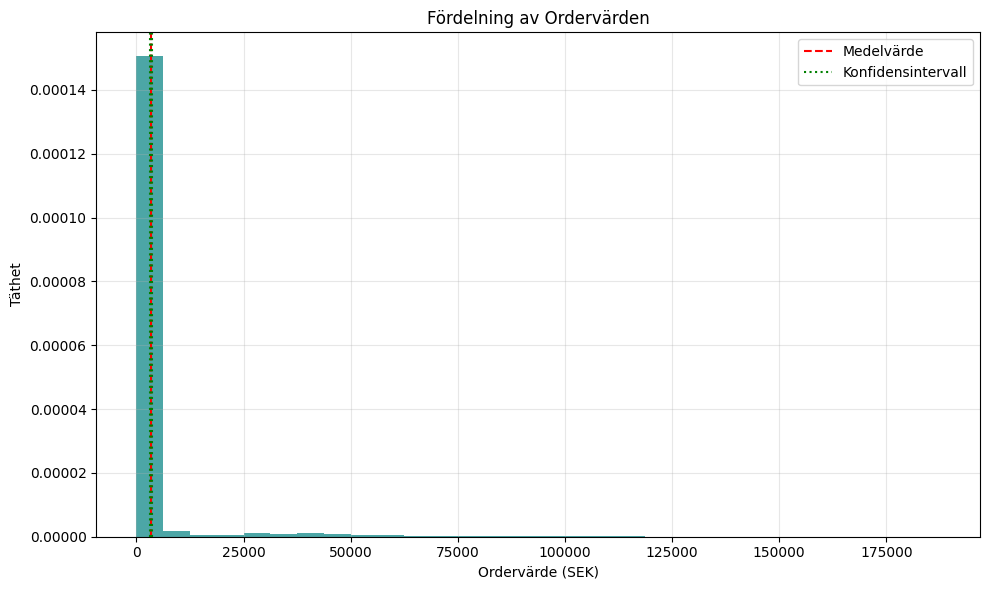

In [322]:
# 6. STATISTISK ANALYS
print("\n6. STATISTISK ANALYS\n")

sales_query = """
SELECT TotalDue  -- Försäljningsbelopp
FROM Sales.SalesOrderHeader
WHERE YEAR(OrderDate) = 2013;  -- Filtrerar för 2013
"""

sales_data = pd.read_sql(sales_query, engine)

# Beräknar statistiska mått
mean_value = sales_data['TotalDue'].mean()  # Medelvärde
std_dev = sales_data['TotalDue'].std()  # Standardavvikelse
n = len(sales_data)  # Antal observationer
t_value = stats.t.ppf(0.975, df=n-1)  # t-värde för konfidensintervall
margin = t_value * (std_dev / np.sqrt(n))  # Felmarginal
conf_int = (mean_value - margin, mean_value + margin)  # Konfidensintervall

print(f"Genomsnittligt försäljningsbelopp: {mean_value:.2f} SEK")
print(f"Standardavvikelse: {std_dev:.2f} SEK")
print(f"Antal ordrar: {n}")
print(f"95% konfidensintervall: ({conf_int[0]:.2f}, {conf_int[1]:.2f}) SEK")

plt.figure(figsize=(10, 6))
plt.hist(sales_data['TotalDue'], bins=30, color='teal', alpha=0.7, density=True)
plt.axvline(mean_value, color='red', linestyle='--', label='Medelvärde')
plt.axvline(conf_int[0], color='green', linestyle=':', label='Konfidensintervall')
plt.axvline(conf_int[1], color='green', linestyle=':')
plt.title('Fördelning av Ordervärden')
plt.xlabel('Ordervärde (SEK)')
plt.ylabel('Täthet')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()